<a href="https://colab.research.google.com/github/s-nakamura333/RUL-prediction/blob/main/RUL_P_20250123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 1. Googleドライブをマウント
drive.mount('/content/drive')

# 学習データと評価データのパス
train_path = '/content/drive/MyDrive/engine/join/train_stats_join.csv'
test_path = '/content/drive/MyDrive/engine/join/test_stats_join.csv'

# データ読み込み
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# 2. 不要なカラムの削除関数（パターン指定で削除）
def filter_columns_by_pattern(df, patterns):
    # パターンに一致するカラムを削除
    drop_columns = [col for col in df.columns if any(pattern in col for pattern in patterns)]
    filtered_df = df.drop(columns=drop_columns, errors='ignore')
    return filtered_df

# 3. unit-cycleを分割する関数
def split_unit_cycle(df):
    # unit-cycleを"unit"と"cycle"に分割
    df[['unit', 'cycle']] = df['unit-cycle'].str.split('-', expand=True)
    # cycleを数値型に変換
    df['cycle'] = pd.to_numeric(df['cycle'])
    return df

# 4. 削除パターン
delete_patterns = ['min', 'median', 'max', 'first', 'last', 'std']

# 5. 不要なカラムを削除し、unit-cycleを分割
train_data = filter_columns_by_pattern(train_data, delete_patterns)
train_data = split_unit_cycle(train_data)

test_data = filter_columns_by_pattern(test_data, delete_patterns)
test_data = split_unit_cycle(test_data)

# 6. 結果を保存
train_data.to_csv('/content/drive/MyDrive/engine/filter/train_processed.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/engine/filter/test_processed.csv', index=False)

print("パターンに基づく不要カラムの削除とunit-cycleの分割が完了しました！✨")


Mounted at /content/drive
パターンに基づく不要カラムの削除とunit-cycleの分割が完了しました！✨


In [ ]:
# 1. cycleの範囲を1～40に絞り込む
train_filtered = train_data[(train_data['cycle'] >= 1) & (train_data['cycle'] <= 40)].copy()
test_filtered = test_data[(test_data['cycle'] >= 1) & (test_data['cycle'] <= 40)].copy()

# 2. 相関行列の計算（数値型カラムのみ対象）
# 数値型カラムを選択する
numeric_columns = train_filtered.select_dtypes(include=[np.number]).columns
correlation_matrix = train_filtered[numeric_columns].corr()

# 目的変数Yとの相関を取得
target_correlation = correlation_matrix['Y'].sort_values(ascending=False)
print("目的変数Yとの相関：")
print(target_correlation)

# 3. 絞り込んだデータを保存
train_filtered.to_csv('/content/drive/MyDrive/engine/filter/train_filtered_cycle_1_40.csv', index=False)
test_filtered.to_csv('/content/drive/MyDrive/engine/filter/test_filtered_cycle_1_40.csv', index=False)

print("cycle範囲の絞り込みと相関行列の計算が完了しました！✨")


目的変数Yとの相関：
Y                    1.000000
LPT_eff_mod_mean     0.665707
LPT_flow_mod_mean    0.641608
hs_mean              0.614923
HPT_flow_mod_mean    0.546135
LPC_flow_mod_mean    0.506119
fan_flow_mod_mean    0.500358
HPT_eff_mod_mean     0.492655
fan_eff_mod_mean     0.488024
HPC_eff_mod_mean     0.484950
LPC_eff_mod_mean     0.479885
HPC_flow_mod_mean    0.419638
SmHPC_mean           0.324448
P2_mean              0.290349
P21_mean             0.289263
P15_mean             0.289198
P50_mean             0.288429
W32_mean             0.287499
W25_mean             0.287413
W22_mean             0.287410
W31_mean             0.287302
W50_mean             0.286986
W48_mean             0.286927
P24_mean             0.286754
W21_mean             0.284885
T2_mean              0.284067
P40_mean             0.278011
P30_mean             0.277954
Ps30_mean            0.276997
P45_mean             0.274734
T24_mean             0.265324
Wf_mean              0.260795
T50_mean             0.200878

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8738
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 46
[LightGBM] [Info] Start training from score 54.872549


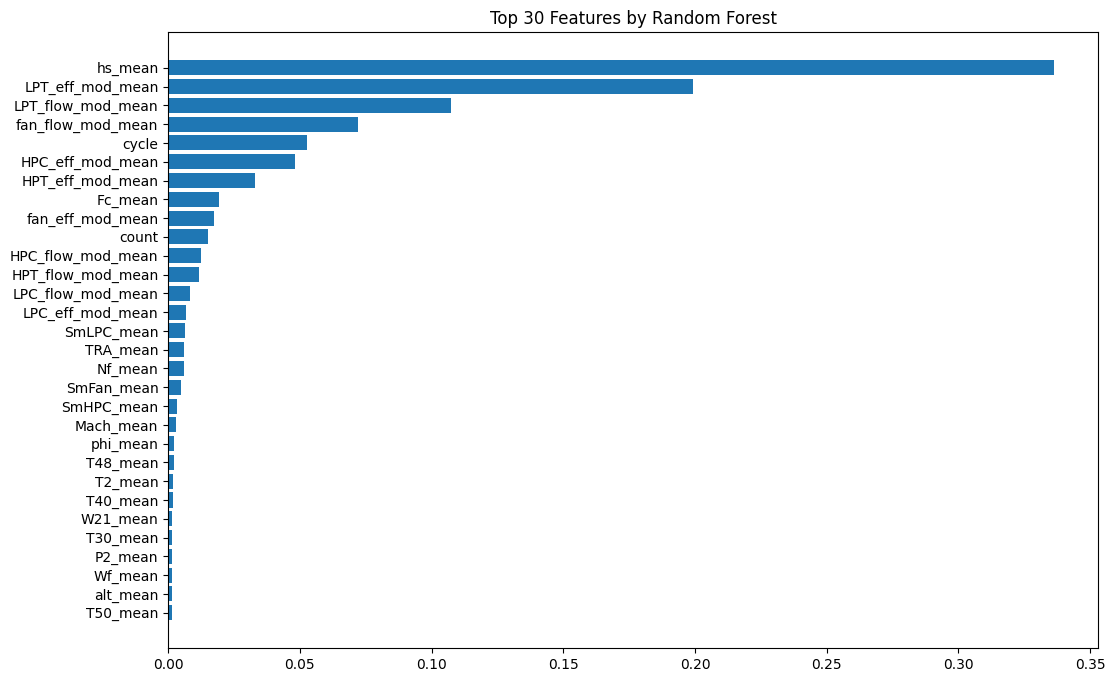

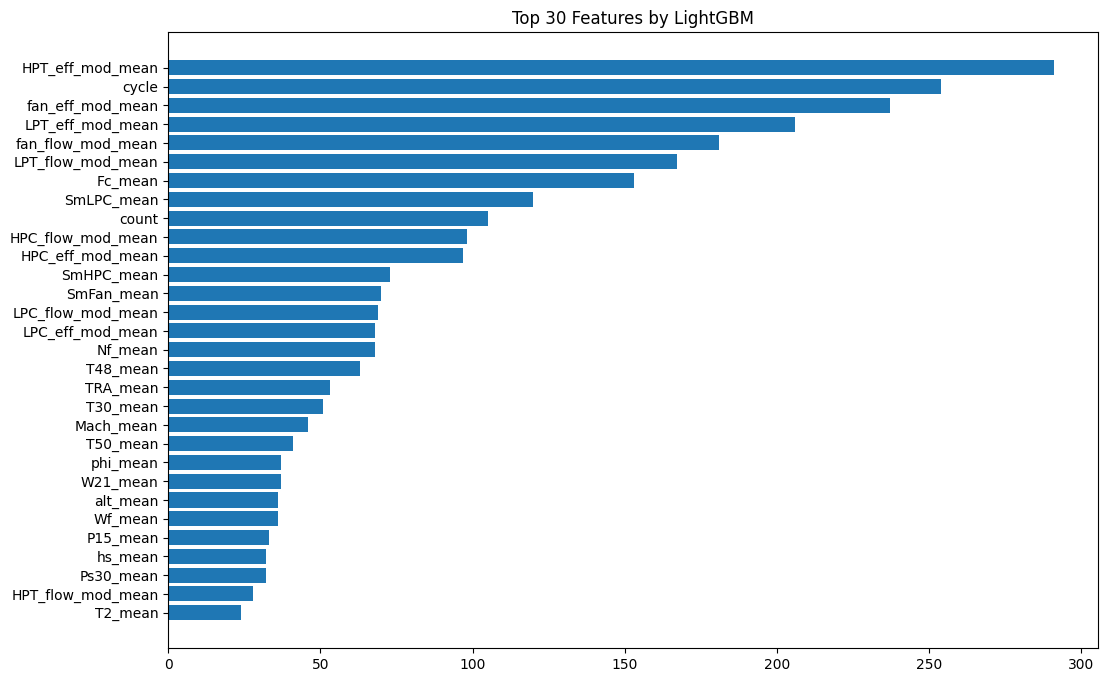

ランダムフォレストとLightGBMの特徴量重要度の調査が完了しました！✨


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. 特徴量と目的変数を分割
# 数値型カラムのみを使用（非数値カラムを除外）
numeric_columns = train_filtered.select_dtypes(include=[np.number]).columns
features = numeric_columns.drop('Y')  # 'Y'は目的変数

X_train = train_filtered[features]
y_train = train_filtered['Y']

# 2. ランダムフォレストで特徴量重要度を計算
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_importances = rf_model.feature_importances_

# 3. LightGBMで特徴量重要度を計算
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_importances = lgb_model.feature_importances_

# 4. ランダムフォレストの上位30特徴量を取得
rf_importances_df = pd.DataFrame({'Feature': features, 'Importance': rf_importances})
rf_importances_df = rf_importances_df.sort_values(by='Importance', ascending=False).head(30)

# 5. LightGBMの上位30特徴量を取得
lgb_importances_df = pd.DataFrame({'Feature': features, 'Importance': lgb_importances})
lgb_importances_df = lgb_importances_df.sort_values(by='Importance', ascending=False).head(30)

# 6. 特徴量重要度を可視化（ランダムフォレスト）
plt.figure(figsize=(12, 8))
plt.barh(rf_importances_df['Feature'], rf_importances_df['Importance'])
plt.title('Top 30 Features by Random Forest')
plt.gca().invert_yaxis()
plt.show()

# 7. 特徴量重要度を可視化（LightGBM）
plt.figure(figsize=(12, 8))
plt.barh(lgb_importances_df['Feature'], lgb_importances_df['Importance'])
plt.title('Top 30 Features by LightGBM')
plt.gca().invert_yaxis()
plt.show()

# 8. 結果を保存
rf_importances_df.to_csv('/content/drive/MyDrive/engine/filter/rf_feature_importances_top30.csv', index=False)
lgb_importances_df.to_csv('/content/drive/MyDrive/engine/filter/lgb_feature_importances_top30.csv', index=False)

print("ランダムフォレストとLightGBMの特徴量重要度の調査が完了しました！✨")


In [ ]:
# ランダムフォレストとLightGBMの結果を統合
# 特徴量とその重要度を一つのリストにまとめる
rf_top_features = rf_importances_df['Feature']
lgb_top_features = lgb_importances_df['Feature']

# 2つの特徴量リストを統合し、重複を削除
important_features = pd.concat([rf_top_features, lgb_top_features]).drop_duplicates().reset_index(drop=True)

# 統合結果をデータフレーム化
important_features_df = pd.DataFrame({'Feature': important_features})

# 結果を保存
output_path = '/content/drive/MyDrive/engine/filter/important_features_list.csv'
important_features_df.to_csv(output_path, index=False)

print(f"重要な特徴量リストを保存しました！保存先: {output_path}")
print("統合された特徴量リストの内容:")
print(important_features_df)


重要な特徴量リストを保存しました！保存先: /content/drive/MyDrive/engine/filter/important_features_list.csv
統合された特徴量リストの内容:
              Feature
0             hs_mean
1    LPT_eff_mod_mean
2   LPT_flow_mod_mean
3   fan_flow_mod_mean
4               cycle
5    HPC_eff_mod_mean
6    HPT_eff_mod_mean
7             Fc_mean
8    fan_eff_mod_mean
9               count
10  HPC_flow_mod_mean
11  HPT_flow_mod_mean
12  LPC_flow_mod_mean
13   LPC_eff_mod_mean
14         SmLPC_mean
15           TRA_mean
16            Nf_mean
17         SmFan_mean
18         SmHPC_mean
19          Mach_mean
20           phi_mean
21           T48_mean
22            T2_mean
23           T40_mean
24           W21_mean
25           T30_mean
26            P2_mean
27            Wf_mean
28           alt_mean
29           T50_mean
30           P15_mean
31          Ps30_mean


In [ ]:
!pip install catboost


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. 重要な特徴量リストの読み込み
important_features_path = '/content/drive/MyDrive/engine/filter/important_features_list.csv'
important_features = pd.read_csv(important_features_path)['Feature'].tolist()

# 2. データの読み込み
train_path = '/content/drive/MyDrive/engine/filter/train_filtered_cycle_1_40.csv'
test_path = '/content/drive/MyDrive/engine/filter/test_filtered_cycle_1_40.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# 特徴量と目的変数を選定
X = train_data[important_features]
y = train_data['Y']

# テストデータ（特徴量のみ）
X_test = test_data[important_features]

# 3. テストデータのfilenameとunitを保持
test_filename_unit = test_data[['filename', 'unit']]

# 4. データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. モデルの定義
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)

# 6. 各モデルで学習
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

# 7. 各モデルの予測値を取得
rf_pred = rf_model.predict(X_val)
lgb_pred = lgb_model.predict(X_val)
cat_pred = cat_model.predict(X_val)

# 8. スタッキング用のデータを作成
stacked_train = np.column_stack((rf_pred, lgb_pred, cat_pred))
stacked_test = np.column_stack((
    rf_model.predict(X_test),
    lgb_model.predict(X_test),
    cat_model.predict(X_test)
))

# 9. スタッキングのメタモデルとして線形回帰を使用
stacking_model = LinearRegression()
stacking_model.fit(stacked_train, y_val)

# 10. 最終予測
final_pred = stacking_model.predict(stacked_test)

# 11. 評価
stacked_val_pred = stacking_model.predict(stacked_train)
mse = mean_squared_error(y_val, stacked_val_pred)
rmse = np.sqrt(mse)
print(f"スタッキングモデルの評価 - MSE: {mse}, RMSE: {rmse}")

# 12. 結果の保存
output_path = '/content/drive/MyDrive/engine/filter/stacking_predictions.csv'
submission = test_filename_unit.copy()  # filenameとunitをコピー
submission['Y'] = final_pred  # 予測結果を追加
submission.to_csv(output_path, index=False)

print(f"スタッキングアンサンブルの予測結果を保存しました！保存先: {output_path}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5423
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 32
[LightGBM] [Info] Start training from score 55.054534
スタッキングモデルの評価 - MSE: 26.566038493124903, RMSE: 5.154225304846976
スタッキングアンサンブルの予測結果を保存しました！保存先: /content/drive/MyDrive/engine/filter/stacking_predictions.csv


In [ ]:
import pandas as pd

# 1. 提出用テンプレートファイルを読み込む
template_path = '/content/drive/MyDrive/engine/join/sample_submission.csv'
submission_template = pd.read_csv(template_path)

# 2. 予測結果を読み込む
predictions_path = '/content/drive/MyDrive/engine/filter/stacking_predictions.csv'
predictions = pd.read_csv(predictions_path)

# 3. 予測結果をfilenameとunitの組み合わせごとにまとめ、中央値を計算
# 必要なカラムが予測結果にあることを前提に処理
grouped_predictions = predictions.groupby(['filename', 'unit'])['Y'].median().reset_index()

# 4. テンプレート内のYを空欄にする
submission_template['Y'] = None

# 5. 計算した中央値をfilenameとunitの組み合わせでテンプレートファイルに入力
for _, row in grouped_predictions.iterrows():
    mask = (submission_template['filename'] == row['filename']) & (submission_template['unit'] == row['unit'])
    submission_template.loc[mask, 'Y'] = row['Y']

# 6. 提出用ファイルを保存
output_path = '/content/drive/MyDrive/engine/filter/stacking_submissions.csv'
submission_template.to_csv(output_path, index=False)

print(f"提出用ファイルを作成しました！保存先: {output_path}")


提出用ファイルを作成しました！保存先: /content/drive/MyDrive/engine/filter/stacking_submissions.csv


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# データ読み込みや前処理は前のコードを流用

# 1. ランダムフォレストのパラメータ調整
print("ランダムフォレストのパラメータ調整中...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"ランダムフォレスト最適パラメータ: {rf_grid.best_params_}")
rf_best_model = rf_grid.best_estimator_

# 2. LightGBMのパラメータ調整
print("LightGBMのパラメータ調整中...")
lgb_params = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [10, 20, 30]
}
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
lgb_grid.fit(X_train, y_train)

print(f"LightGBM最適パラメータ: {lgb_grid.best_params_}")
lgb_best_model = lgb_grid.best_estimator_

# 3. CatBoostのパラメータ調整
print("CatBoostのパラメータ調整中...")
cat_params = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5]
}
cat_model = CatBoostRegressor(random_state=42, verbose=0)
cat_grid = GridSearchCV(cat_model, cat_params, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
cat_grid.fit(X_train, y_train)

print(f"CatBoost最適パラメータ: {cat_grid.best_params_}")
cat_best_model = cat_grid.best_estimator_

# 4. ベストモデルで評価
print("各モデルの評価中...")
models = {
    'RandomForest': rf_best_model,
    'LightGBM': lgb_best_model,
    'CatBoost': cat_best_model
}

for name, model in models.items():
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}")


ランダムフォレストのパラメータ調整中...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
ランダムフォレスト最適パラメータ: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
LightGBMのパラメータ調整中...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5423
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 32
[LightGBM] [Info] Start training from score 55.054534
LightGBM最適パラメータ: {'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 31}
CatBoostのパラメータ調整中...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
CatBoost最適パラメータ: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
各モデルの評価中...
RandomForest - 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# 1. データの読み込み
train_path = '/content/drive/MyDrive/engine/filter/train_filtered_cycle_1_40.csv'
test_path = '/content/drive/MyDrive/engine/filter/test_filtered_cycle_1_40.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# 必要なカラムの選定
important_features_path = '/content/drive/MyDrive/engine/filter/important_features_list.csv'
important_features = pd.read_csv(important_features_path)['Feature'].tolist()

X = train_data[important_features]
y = train_data['Y']
X_test = test_data[important_features]

# テストデータのfilenameとunitを保持
test_filename_unit = test_data[['filename', 'unit']]

# 2. データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. モデルの定義（パラメータは調整済みのものを使用）
rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
lgb_model = lgb.LGBMRegressor(learning_rate=0.05, max_depth=20, min_child_samples=10, n_estimators=300, num_leaves=31, random_state=42)
cat_model = CatBoostRegressor(depth=6, iterations=300, l2_leaf_reg=5, learning_rate=0.1, random_state=42, verbose=0)

# 4. モデルの学習
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

# 5. 各モデルの予測値を取得
rf_pred = rf_model.predict(X_val)
lgb_pred = lgb_model.predict(X_val)
cat_pred = cat_model.predict(X_val)

# テストデータの予測
rf_test_pred = rf_model.predict(X_test)
lgb_test_pred = lgb_model.predict(X_test)
cat_test_pred = cat_model.predict(X_test)

# 6. スタッキング用データの作成
stacked_train = np.column_stack((rf_pred, lgb_pred, cat_pred))
stacked_test = np.column_stack((rf_test_pred, lgb_test_pred, cat_test_pred))

# 7. メタモデル（線形回帰）を使用したスタッキング
stacking_model = LinearRegression()
stacking_model.fit(stacked_train, y_val)

# 8. 最終予測
final_pred = stacking_model.predict(stacked_test)

# 9. 評価
stacked_val_pred = stacking_model.predict(stacked_train)
mse = mean_squared_error(y_val, stacked_val_pred)
rmse = np.sqrt(mse)
print(f"スタッキングモデルの評価 - MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# 10. 結果の保存
output_path = '/content/drive/MyDrive/engine/filter/stacking_predictions.csv'
submission = test_filename_unit.copy()
submission['Y'] = final_pred
submission.to_csv(output_path, index=False)

print(f"スタッキングアンサンブルの予測結果を保存しました！保存先: {output_path}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5423
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 32
[LightGBM] [Info] Start training from score 55.054534
スタッキングモデルの評価 - MSE: 23.7526, RMSE: 4.8737
スタッキングアンサンブルの予測結果を保存しました！保存先: /content/drive/MyDrive/engine/filter/stacking_predictions.csv


In [ ]:
import pandas as pd

# 1. 提出用テンプレートファイルを読み込む
template_path = '/content/drive/MyDrive/engine/join/sample_submission.csv'
submission_template = pd.read_csv(template_path)

# 2. 予測結果を読み込む
predictions_path = '/content/drive/MyDrive/engine/filter/stacking_predictions.csv'
predictions = pd.read_csv(predictions_path)

# 3. 予測結果をfilenameとunitの組み合わせごとにまとめ、中央値を計算
# 必要なカラムが予測結果にあることを前提に処理
grouped_predictions = predictions.groupby(['filename', 'unit'])['Y'].median().reset_index()

# 4. テンプレート内のYを空欄にする
submission_template['Y'] = None

# 5. 計算した中央値をfilenameとunitの組み合わせでテンプレートファイルに入力
for _, row in grouped_predictions.iterrows():
    mask = (submission_template['filename'] == row['filename']) & (submission_template['unit'] == row['unit'])
    submission_template.loc[mask, 'Y'] = row['Y']

# 6. 提出用ファイルを保存
output_path = '/content/drive/MyDrive/engine/filter/stacking_submission2.csv'
submission_template.to_csv(output_path, index=False)

print(f"提出用ファイルを作成しました！保存先: {output_path}")


提出用ファイルを作成しました！保存先: /content/drive/MyDrive/engine/filter/stacking_submission2.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

# 1. データの読み込み
train_path = '/content/drive/MyDrive/engine/filter/train_filtered_cycle_1_40.csv'
test_path = '/content/drive/MyDrive/engine/filter/test_filtered_cycle_1_40.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# 必要なカラムの選定
important_features_path = '/content/drive/MyDrive/engine/filter/important_features_list.csv'
important_features = pd.read_csv(important_features_path)['Feature'].tolist()

X = train_data[important_features]
y = train_data['Y']
X_test = test_data[important_features]

# テストデータのfilenameとunitを保持
test_filename_unit = test_data[['filename', 'unit']]

# 2. データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. モデルの定義（正則化強化したLightGBMの設定を含む）
rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.05,
    max_depth=20,
    min_child_samples=10,
    n_estimators=300,
    num_leaves=31,
    lambda_l1=0.1,  # L1正則化
    lambda_l2=0.5,  # L2正則化
    feature_fraction=0.8,  # 特徴量の一部をランダムに使用
    bagging_fraction=0.8,  # データの一部をランダムに使用
    bagging_freq=5,  # バギングの頻度
    random_state=42
)
cat_model = CatBoostRegressor(depth=6, iterations=300, l2_leaf_reg=5, learning_rate=0.1, random_state=42, verbose=0)

# 4. モデルの学習
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

# 5. 各モデルの予測値を取得
rf_pred = rf_model.predict(X_val)
lgb_pred = lgb_model.predict(X_val)
cat_pred = cat_model.predict(X_val)

# テストデータの予測
rf_test_pred = rf_model.predict(X_test)
lgb_test_pred = lgb_model.predict(X_test)
cat_test_pred = cat_model.predict(X_test)

# 6. スタッキング用データの作成
stacked_train = np.column_stack((rf_pred, lgb_pred, cat_pred))
stacked_test = np.column_stack((rf_test_pred, lgb_test_pred, cat_test_pred))

# 7. メタモデルにLightGBMを採用
stacking_model = lgb.LGBMRegressor(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=200,
    lambda_l1=0.2,  # メタモデルのL1正則化
    lambda_l2=0.4,  # メタモデルのL2正則化
    random_state=42
)
stacking_model.fit(stacked_train, y_val)

# 8. 最終予測
final_pred = stacking_model.predict(stacked_test)

# 9. 評価
stacked_val_pred = stacking_model.predict(stacked_train)
mse = mean_squared_error(y_val, stacked_val_pred)
rmse = np.sqrt(mse)
print(f"スタッキングモデル（LightGBMメタモデル）の評価 - MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# 10. 結果の保存
output_path = '/content/drive/MyDrive/engine/filter/stacking_predictions_lightgbm_meta.csv'
submission = test_filename_unit.copy()
submission['Y'] = final_pred
submission.to_csv(output_path, index=False)

print(f"LightGBMをメタモデルにしたスタッキングアンサンブルの予測結果を保存しました！保存先: {output_path}")


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[Ligh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
スタッキングモデル（LightGBMメタモデル）の評価 - MSE: 14.3984, RMSE: 3.7945
LightGBMをメタモデルにしたスタッキングアンサンブルの予測結果を保存しました！保存先: /content/drive/MyDrive/engine/filter/stacking_predictions_lightgbm_meta.csv


In [ ]:
import pandas as pd

# 1. 提出用テンプレートファイルを読み込む
template_path = '/content/drive/MyDrive/engine/join/sample_submission.csv'
submission_template = pd.read_csv(template_path)

# 2. 予測結果を読み込む
predictions_path = '/content/drive/MyDrive/engine/filter/stacking_predictions_lightgbm_meta.csv'
predictions = pd.read_csv(predictions_path)

# 3. 予測結果をfilenameとunitの組み合わせごとにまとめ、中央値を計算
# 必要なカラムが予測結果にあることを前提に処理
grouped_predictions = predictions.groupby(['filename', 'unit'])['Y'].median().reset_index()

# 4. テンプレート内のYを空欄にする
submission_template['Y'] = None

# 5. 計算した中央値をfilenameとunitの組み合わせでテンプレートファイルに入力
for _, row in grouped_predictions.iterrows():
    mask = (submission_template['filename'] == row['filename']) & (submission_template['unit'] == row['unit'])
    submission_template.loc[mask, 'Y'] = row['Y']

# 6. 提出用ファイルを保存
output_path = '/content/drive/MyDrive/engine/results/submissionlightgbm_meta.csv'
submission_template.to_csv(output_path, index=False)

print(f"提出用ファイルを作成しました！保存先: {output_path}")


提出用ファイルを作成しました！保存先: /content/drive/MyDrive/engine/results/submissionlightgbm_meta.csv


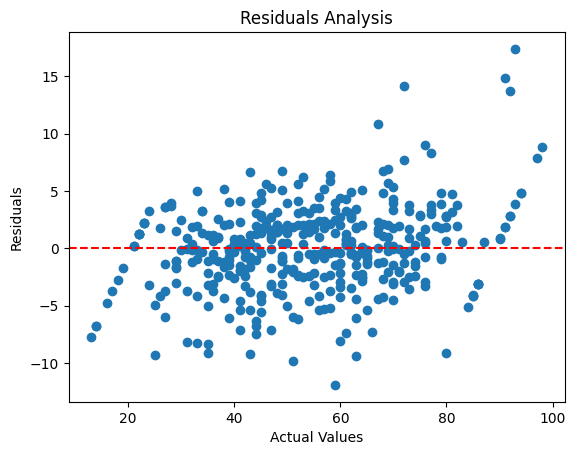

In [ ]:
import matplotlib.pyplot as plt

residuals = y_val - stacked_val_pred
plt.scatter(y_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Analysis')
plt.show()


In [ ]:
import pandas as pd
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. データの読み込み
train_path = '/content/drive/MyDrive/engine/filter/train_filtered_cycle_1_40.csv'
test_path = '/content/drive/MyDrive/engine/filter/test_filtered_cycle_1_40.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# 必要なカラムの選定
important_features_path = '/content/drive/MyDrive/engine/filter/important_features_list.csv'
important_features = pd.read_csv(important_features_path)['Feature'].tolist()

# 2. 新しい特徴量として filename と unit の組み合わせを作成
train_data['filename_unit'] = train_data['filename'] + "_" + train_data['unit'].astype(str)
test_data['filename_unit'] = test_data['filename'] + "_" + test_data['unit'].astype(str)

# 3. 特徴量と目的変数を選定
X = train_data[important_features + ['filename', 'unit', 'filename_unit']]
y = train_data['Y']
X_test = test_data[important_features + ['filename', 'unit', 'filename_unit']]

# カテゴリ型のカラムを指定
categorical_features = ['filename', 'unit', 'filename_unit']

# カテゴリ型に変換
for col in categorical_features:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# 4. データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. LightGBMのモデル構築
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.05,
    max_depth=20,
    n_estimators=300,
    num_leaves=31,
    lambda_l1=0.1,
    lambda_l2=0.2,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42
)

# 手動で学習回数を管理するロジック
best_rmse = float("inf")
best_iteration = 0
for i in range(1, 301):  # 最大300回の学習
    lgb_model.set_params(n_estimators=i)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_features
    )
    y_val_pred = lgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_iteration = i

print(f"LightGBM 最適反復回数: {best_iteration}, 最小RMSE: {best_rmse}")

# 最適な反復回数で再学習
lgb_model.set_params(n_estimators=best_iteration)
lgb_model.fit(
    X_train, y_train,
    categorical_feature=categorical_features
)

# 6. CatBoostのモデル構築
cat_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_features,
    random_state=42,
    verbose=False
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

# 7. テストデータの予測
lgb_test_pred = lgb_model.predict(X_test)
cat_test_pred = cat_model.predict(X_test)

# 8. 予測値の保存
lgb_output_path = '/content/drive/MyDrive/engine/results/lgb_predictions.csv'
cat_output_path = '/content/drive/MyDrive/engine/results/cat_predictions.csv'

pd.DataFrame({'Y': lgb_test_pred}).to_csv(lgb_output_path, index=False)
pd.DataFrame({'Y': cat_test_pred}).to_csv(cat_output_path, index=False)

print(f"LightGBM予測値を保存しました！保存先: {lgb_output_path}")
print(f"CatBoost予測値を保存しました！保存先: {cat_output_path}")


<ipython-input-22-e11d61fadeae>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
<ipython-input-22-e11d61fadeae>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')
<ipython-input-22-e11d61fadeae>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Info] Total Bins 5497
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 35
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Start training from score 55.054534
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


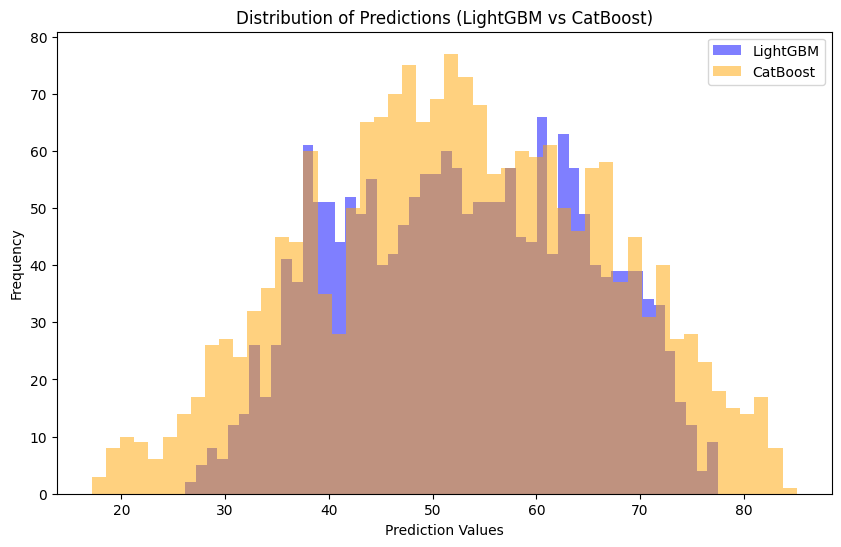

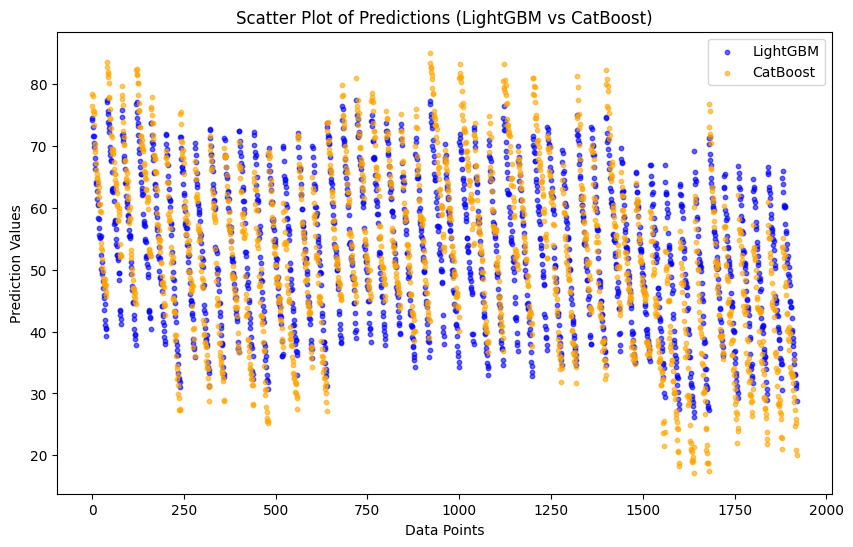

LightGBMとCatBoostの予測値の相関係数: 0.9028


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 予測値の読み込み
lgb_predictions_path = '/content/drive/MyDrive/engine/results/lgb_predictions.csv'
cat_predictions_path = '/content/drive/MyDrive/engine/results/cat_predictions.csv'

lgb_predictions = pd.read_csv(lgb_predictions_path)
cat_predictions = pd.read_csv(cat_predictions_path)

# 2. ヒストグラムで分布を比較
plt.figure(figsize=(10, 6))
plt.hist(lgb_predictions['Y'], bins=50, alpha=0.5, label='LightGBM', color='blue')
plt.hist(cat_predictions['Y'], bins=50, alpha=0.5, label='CatBoost', color='orange')
plt.xlabel('Prediction Values')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions (LightGBM vs CatBoost)')
plt.legend()
plt.show()

# 3. 散布図で比較
plt.figure(figsize=(10, 6))
plt.scatter(range(len(lgb_predictions)), lgb_predictions['Y'], alpha=0.6, label='LightGBM', color='blue', s=10)
plt.scatter(range(len(cat_predictions)), cat_predictions['Y'], alpha=0.6, label='CatBoost', color='orange', s=10)
plt.xlabel('Data Points')
plt.ylabel('Prediction Values')
plt.title('Scatter Plot of Predictions (LightGBM vs CatBoost)')
plt.legend()
plt.show()

# 4. 相関係数を計算
correlation = lgb_predictions['Y'].corr(cat_predictions['Y'])
print(f"LightGBMとCatBoostの予測値の相関係数: {correlation:.4f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# 1. 予測値の読み込み
lgb_predictions_path = '/content/drive/MyDrive/engine/results/lgb_predictions.csv'
cat_predictions_path = '/content/drive/MyDrive/engine/results/cat_predictions.csv'

lgb_predictions = pd.read_csv(lgb_predictions_path)
cat_predictions = pd.read_csv(cat_predictions_path)

# 2. アンサンブル（重み付き平均）
ensemble_weight_cat = 0.6  # CatBoostの重み
ensemble_weight_lgb = 0.4  # LightGBMの重み

ensemble_predictions = (
    ensemble_weight_cat * cat_predictions['Y'] +
    ensemble_weight_lgb * lgb_predictions['Y']
)

# 4. アンサンブル予測値を保存
ensemble_output_path = '/content/drive/MyDrive/engine/results/ensemble_predictions.csv'
pd.DataFrame({'Y': ensemble_predictions}).to_csv(ensemble_output_path, index=False)

print(f"アンサンブル予測値を保存しました！保存先: {ensemble_output_path}")


アンサンブル予測値を保存しました！保存先: /content/drive/MyDrive/engine/results/ensemble_predictions.csv


In [ ]:
import pandas as pd

# 1. アンサンブル予測値の読み込み
ensemble_predictions_path = '/content/drive/MyDrive/engine/results/ensemble_predictions.csv'
ensemble_predictions = pd.read_csv(ensemble_predictions_path)

# テストデータのfilenameとunitを読み込み
test_data_path = '/content/drive/MyDrive/engine/filter/test_filtered_cycle_1_40.csv'
test_data = pd.read_csv(test_data_path)

# テストデータからfilenameとunitを取得して結合
test_data_combined = test_data[['filename', 'unit']].copy()
test_data_combined['Y'] = ensemble_predictions['Y']

# 2. filenameとunitごとに中央値を計算
grouped_predictions = test_data_combined.groupby(['filename', 'unit'], as_index=False)['Y'].median()

# 3. 提出テンプレートの読み込み
template_path = '/content/drive/MyDrive/engine/join/sample_submission.csv'
submission_template = pd.read_csv(template_path)

# 4. 提出テンプレートに中央値を反映
# テンプレート内のYを初期化（空にする）
submission_template['Y'] = None

# filenameとunitで一致する行に中央値を挿入
for _, row in grouped_predictions.iterrows():
    mask = (submission_template['filename'] == row['filename']) & (submission_template['unit'] == row['unit'])
    submission_template.loc[mask, 'Y'] = row['Y']

# 5. 提出ファイルの保存
submission_output_path = '/content/drive/MyDrive/engine/results/submission_ensemble_median.csv'
submission_template.to_csv(submission_output_path, index=False)

print(f"提出用ファイルを作成しました！保存先: {submission_output_path}")


提出用ファイルを作成しました！保存先: /content/drive/MyDrive/engine/results/submission_ensemble_median.csv


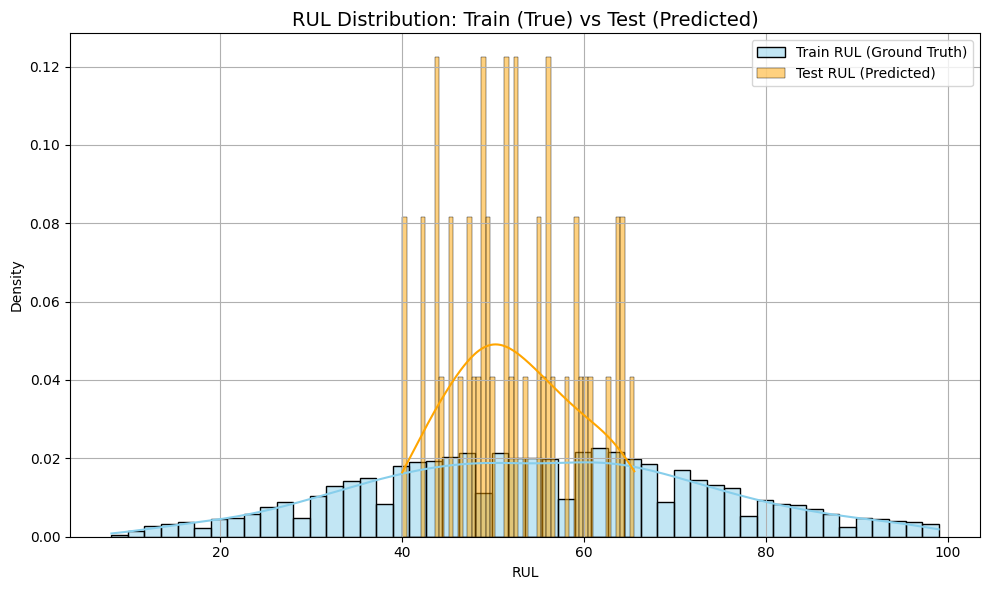

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# グラフ描画用の設定
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, color='skyblue', label='Train RUL (Ground Truth)', kde=True, stat='density')
sns.histplot(grouped_predictions['Y'], bins=50, color='orange', label='Test RUL (Predicted)', kde=True, stat='density')

plt.title('RUL Distribution: Train (True) vs Test (Predicted)', fontsize=14)
plt.xlabel('RUL')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# 保存
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/engine/results/rul_distribution_comparison.png', dpi=300)
plt.show()


<ipython-input-29-79d2d911b14a>:26: UserWarning: Glyph 20351 (\N{CJK UNIFIED IDEOGRAPH-4F7F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-29-79d2d911b14a>:26: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-29-79d2d911b14a>:26: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-29-79d2d911b14a>:26: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-29-79d2d911b14a>:26: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-29-79d2d911b14a>:26: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-29-79d2d911b14a>:26: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight

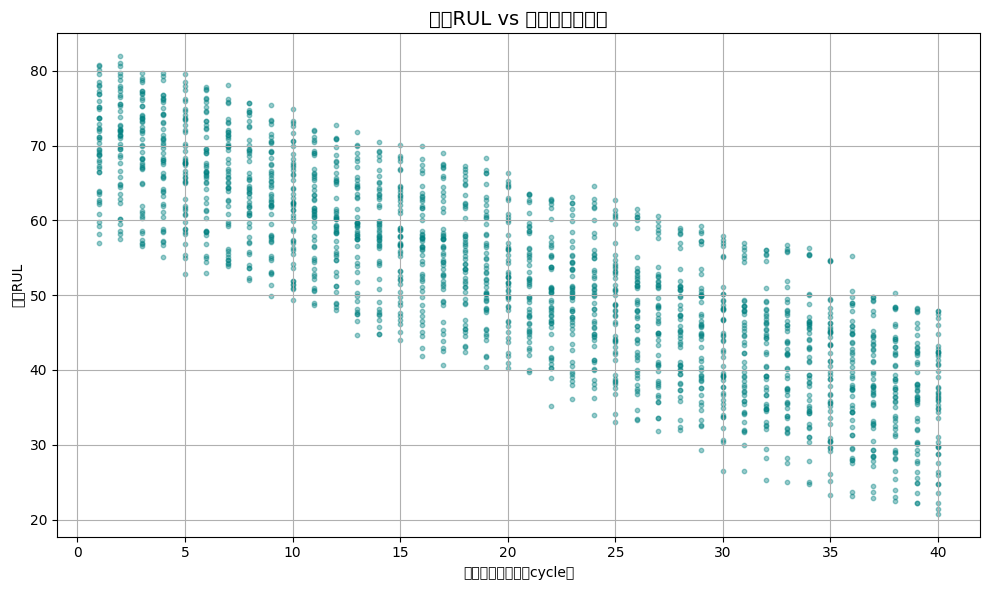

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 予測結果とテストデータの読み込み
pred_path = '/content/drive/MyDrive/engine/results/ensemble_predictions.csv'
test_path = '/content/drive/MyDrive/engine/filter/test_filtered_cycle_1_40.csv'

pred_df = pd.read_csv(pred_path)
test_df = pd.read_csv(test_path)

# 必要な情報を結合
test_df = test_df.copy()
test_df['predicted_RUL'] = pred_df['Y']

# filename + unit + cycle + predicted RUL で確認用データ作成
merged_df = test_df[['filename', 'unit', 'cycle', 'predicted_RUL']]

# プロット
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['cycle'], merged_df['predicted_RUL'], alpha=0.4, color='teal', s=10)

plt.title('予測RUL vs 使用サイクル数', fontsize=14)
plt.xlabel('使用サイクル数（cycle）')
plt.ylabel('予測RUL')
plt.grid(True)
plt.tight_layout()

# 保存
plt.savefig('/content/drive/MyDrive/engine/results/rul_vs_cycle_scatter.png', dpi=300)
plt.show()


In [ ]:
!apt-get -y install fonts-ipafont-gothic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 2s (5,460 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

In [ ]:
# フォントインストール
!apt-get -y install fonts-ipafont-gothic

# ランタイム再起動なしで即認識させるために、キャッシュクリア＋明示指定
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

# ゴシック体のパスを指定
font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf"
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 設定されたフォントの確認（念のため）
print("使用フォント:", font_prop.get_name())


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
使用フォント: IPAGothic


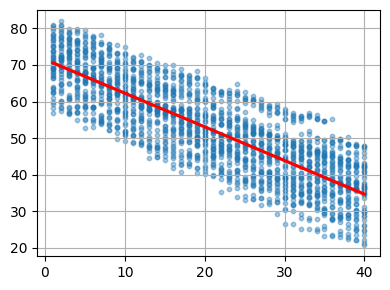

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))  # やや横長に調整
sns.regplot(
    x='cycle',
    y='predicted_RUL',
    data=merged_df,
    scatter_kws={'s':10, 'alpha':0.4},
    line_kws={'color': 'red'}
)

# タイトルと軸ラベルは消しておく（パワポで後入れ）
plt.title('', fontsize=0)
plt.xlabel('', fontsize=0)
plt.ylabel('', fontsize=0)

plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/engine/results/rul_vs_cycle_final.png', dpi=300)
plt.show()


Text(0, 0.5, '予測RUL')

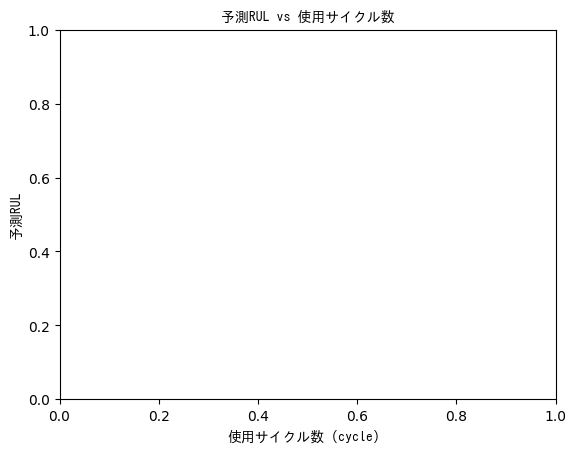

In [ ]:
plt.title('予測RUL vs 使用サイクル数', fontsize=14, fontproperties=font_prop)
plt.xlabel('使用サイクル数（cycle）', fontproperties=font_prop)
plt.ylabel('予測RUL', fontproperties=font_prop)
